In [1]:
#  EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm

# кластерный анализ
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN

# регрессия
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
import shap

import os

# вывод результата клетки без print
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# отключим предупреждения Anaconda (https://habr.com/ru/companies/ods/articles/323210/)
import warnings
warnings.simplefilter("ignore")

### Постановка задачи
Требуется провести EDA БД, а также предсказать целевую переменную **G3 (Итоговая оценка)**

Описание датасета

    1. school: школа ученика (binary: 'GP' - Gabriel Pereira or 'MS' - Mousinho da Silveira)
    2. sex: пол (binary: 'F' - female or 'M' - male)
    3. age: возраст (numeric: from 15 to 22)
    4. address: тип домашнего адреса (binary: 'U' - urban or 'R' - rural)
    5. famsize: размер семьи (binary: 'LE3' - less or equal to 3 or 'GT3' - greater than 3)
    6. Pstatus: статус совместного проживания родителей (binary: 'T' - living together or 'A' - apart)
    7. Medu: образование матери (numeric: 0 - none, 1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education)
    8. Fedu: образование отца (numeric: 0 - none, 1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education)
    9. Mjob: работа матери (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
    10. Fjob: fработа отца (nominal: 'teacher', 'health' care related, civil 'services' (e.g. administrative or police), 'at_home' or 'other')
    11. reason: причина для выбора школы (nominal: close to 'home', school 'reputation', 'course' preference or 'other')
    12. guardian: опекун (nominal: 'mother', 'father' or 'other')
    13. traveltime: время дороги до школы (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
    14. studytime: еженедельное учебное врем (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
    15. failures: количество неудач на занятиях в прошлом (numeric: n if 1<=n<3, else 4)
    16. schoolsup: дополнительная образовательная поддержка (binary: yes or no)
    17. famsup: семейная образовательная поддержка (binary: yes or no)
    18. paid: дополнительные платные занятия в рамках предмета (Math) (binary: yes or no)
    19. activities: внеклассные мероприятия (binary: yes or no)
    20. nursery: посещал детский сад (binary: yes or no)
    21. higher: хочет получить высшее образование (binary: yes or no)
    22. internet: доступ в Интернет дома (binary: yes or no)
    23. romantic: имеет романтические отношения (binary: yes or no)
    24. famrel: качество семейных отношений (numeric: from 1 - very bad to 5 - excellent)
    25. freetime: свободное время после школы (numeric: from 1 - very low to 5 - very high)
    26. goout: прогулки с друзьями (numeric: from 1 - very low to 5 - very high)
    27. Dalc: употребление алкоголя в рабочий день (numeric: from 1 - very low to 5 - very high)
    28. Walc: употребление алкоголя в выходные дни (numeric: from 1 - very low to 5 - very high)
    29. health: текущее состояние здоровья (numeric: from 1 - very bad to 5 - very good)
    30. absences: количество пропусков занятий в школе (numeric: from 0 to 93)
    31. Grades: оценки за первый период (G1), второй период (G2), итоговая оценка (G3).

In [2]:
df = pd.read_csv(os.path.join(os.getcwd(), r'Maths 2.csv'))  # указываем директорию файла
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,MS,M,20,U,LE3,A,2,2,services,services,...,5,5,4,4,5,4,11,9,9,9
391,MS,M,17,U,LE3,T,3,1,services,services,...,2,4,5,3,4,2,3,14,16,16
392,MS,M,21,R,GT3,T,1,1,other,other,...,5,5,3,3,3,3,3,10,8,7
393,MS,M,18,R,LE3,T,3,2,services,other,...,4,4,1,3,4,5,0,11,12,10


In [3]:
df_cat = df.copy()
for param in df_cat.columns[
             :-4
             ]:  # все параметры кроме численных (оценки и количество пропусков) можно закодировать
    if param == "age":
        continue
    else:
        df_cat[param] = df_cat[param].astype("category").cat.codes

# возраст считается численным признаком, так как переведя в категорию, теряется информация 
# (https://stats.stackexchange.com/questions/413193/is-age-categorical-or-quantitative-or-both)

### EDA

#### Проверка переменных

In [4]:
df.info()  # проверка типа данных параметров

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      395 non-null    object
 1   sex         395 non-null    object
 2   age         395 non-null    int64 
 3   address     395 non-null    object
 4   famsize     395 non-null    object
 5   Pstatus     395 non-null    object
 6   Medu        395 non-null    int64 
 7   Fedu        395 non-null    int64 
 8   Mjob        395 non-null    object
 9   Fjob        395 non-null    object
 10  reason      395 non-null    object
 11  guardian    395 non-null    object
 12  traveltime  395 non-null    int64 
 13  studytime   395 non-null    int64 
 14  failures    395 non-null    int64 
 15  schoolsup   395 non-null    object
 16  famsup      395 non-null    object
 17  paid        395 non-null    object
 18  activities  395 non-null    object
 19  nursery     395 non-null    object
 20  higher    

In [5]:
df.isnull().sum()  #  проверка пропусков (все чисто)

school        0
sex           0
age           0
address       0
famsize       0
Pstatus       0
Medu          0
Fedu          0
Mjob          0
Fjob          0
reason        0
guardian      0
traveltime    0
studytime     0
failures      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
G1            0
G2            0
G3            0
dtype: int64

### Анализ целевой переменной

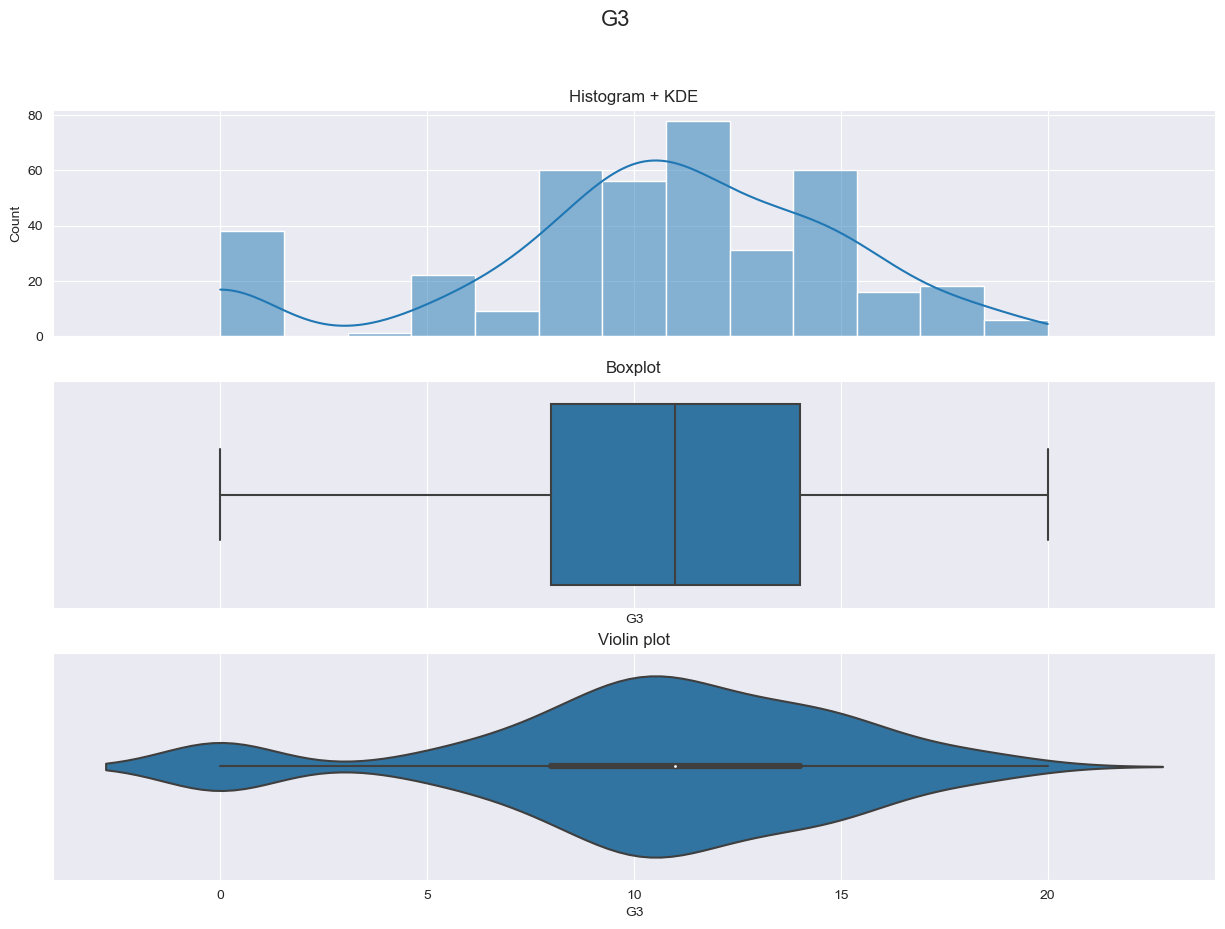

In [6]:
def plot_comparison(x, title):  # # посмотрим распределение целевого признака (https://edu.hse.ru/mod/page/view.php?id=489275)
    fig, ax = plt.subplots(3, 1, sharex=True, figsize=(15,10))
    sns.histplot(x=x, ax=ax[0], kde=True)
    ax[0].set_title('Histogram + KDE')
    sns.boxplot(x=x, ax=ax[1])
    ax[1].set_title('Boxplot')
    sns.violinplot(x=x, ax=ax[2])
    ax[2].set_title('Violin plot')
    fig.suptitle(title, fontsize=16)
    plt.show();
    
plot_comparison(df['G3'], 'G3')

### Выбросы

In [7]:
df['G3'].describe()  # по перцентилям

q3 = np.percentile(df['G3'], 75)
q1 = np.percentile(df['G3'], 25)

iqr = q3 - q1
iqr_bot = q1 - 1.5*iqr
iqr_top = q3 + 1.5*iqr

print(iqr_bot, iqr_top)  # ниже минимума и выше максимума

count    395.000000
mean      10.415190
std        4.581443
min        0.000000
25%        8.000000
50%       11.000000
75%       14.000000
max       20.000000
Name: G3, dtype: float64

-1.0 23.0


In [8]:
mean = df['G3'].mean()  # по std
std = df['G3'].std()
std_bot = mean - 2.5*std
std_top = mean + 2.5*std
print(std_bot, std_top) # опять ниже минимума и выше максимума

-1.0384166540768867 21.86879640091233


In [9]:
df['Z-score'] = scipy.stats.zscore(df['G3'])

<AxesSubplot:>

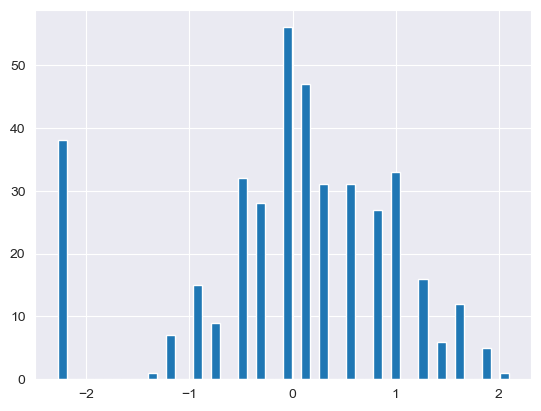

In [10]:
df['Z-score'].hist(bins=50)  # по z-критерию

In [11]:
df[df['Z-score'].abs() > 2] # 39 студентов можно считать выбросами по G3 если пороговое значение z=2 (один студент написал на максимальный балл)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3,Z-score
47,GP,M,16,U,GT3,T,4,3,health,services,...,2,2,1,1,2,4,19,19,20,2.094748
128,GP,M,18,R,GT3,T,2,2,services,other,...,3,3,1,2,4,0,7,4,0,-2.276226
130,GP,F,15,R,GT3,T,3,4,services,teacher,...,2,2,2,2,5,0,12,0,0,-2.276226
131,GP,F,15,U,GT3,T,1,1,at_home,other,...,3,3,1,2,4,0,8,0,0,-2.276226
134,GP,M,15,R,GT3,T,3,4,at_home,teacher,...,3,3,1,1,5,0,9,0,0,-2.276226
135,GP,F,15,U,GT3,T,4,4,services,at_home,...,3,3,1,1,5,0,11,0,0,-2.276226
136,GP,M,17,R,GT3,T,3,4,at_home,other,...,4,5,2,4,5,0,10,0,0,-2.276226
137,GP,F,16,U,GT3,A,3,3,other,other,...,3,2,1,1,5,0,4,0,0,-2.276226
140,GP,M,15,U,GT3,T,4,3,teacher,services,...,2,2,1,1,3,0,7,9,0,-2.276226
144,GP,M,17,U,GT3,T,2,1,other,other,...,4,5,1,2,5,0,5,0,0,-2.276226


In [12]:
df_no_outliers = df[~(df['Z-score'].abs() > 2)]  

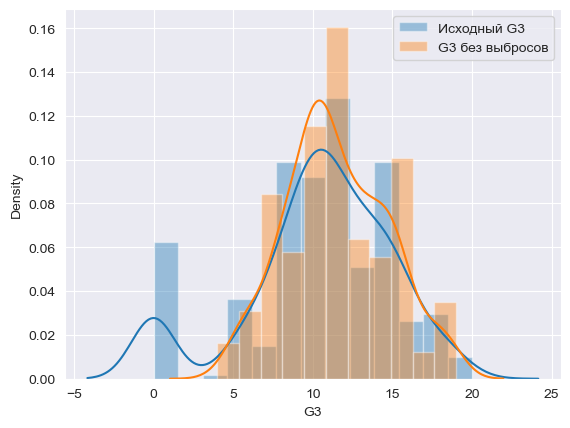

In [13]:
sns.distplot(df['G3'], label='Исходный G3') 
sns.distplot(df_no_outliers['G3'], label='G3 без выбросов')
plt.legend();

In [14]:
df['G3'].mean()
df_no_outliers['G3'].mean()

10.415189873417722

11.5

In [15]:
df.drop('Z-score', axis=1, inplace=True)

### Визуализация параметров

По каждому из параметров, построим боксплоты для представления количества-counts значений по каждому из них

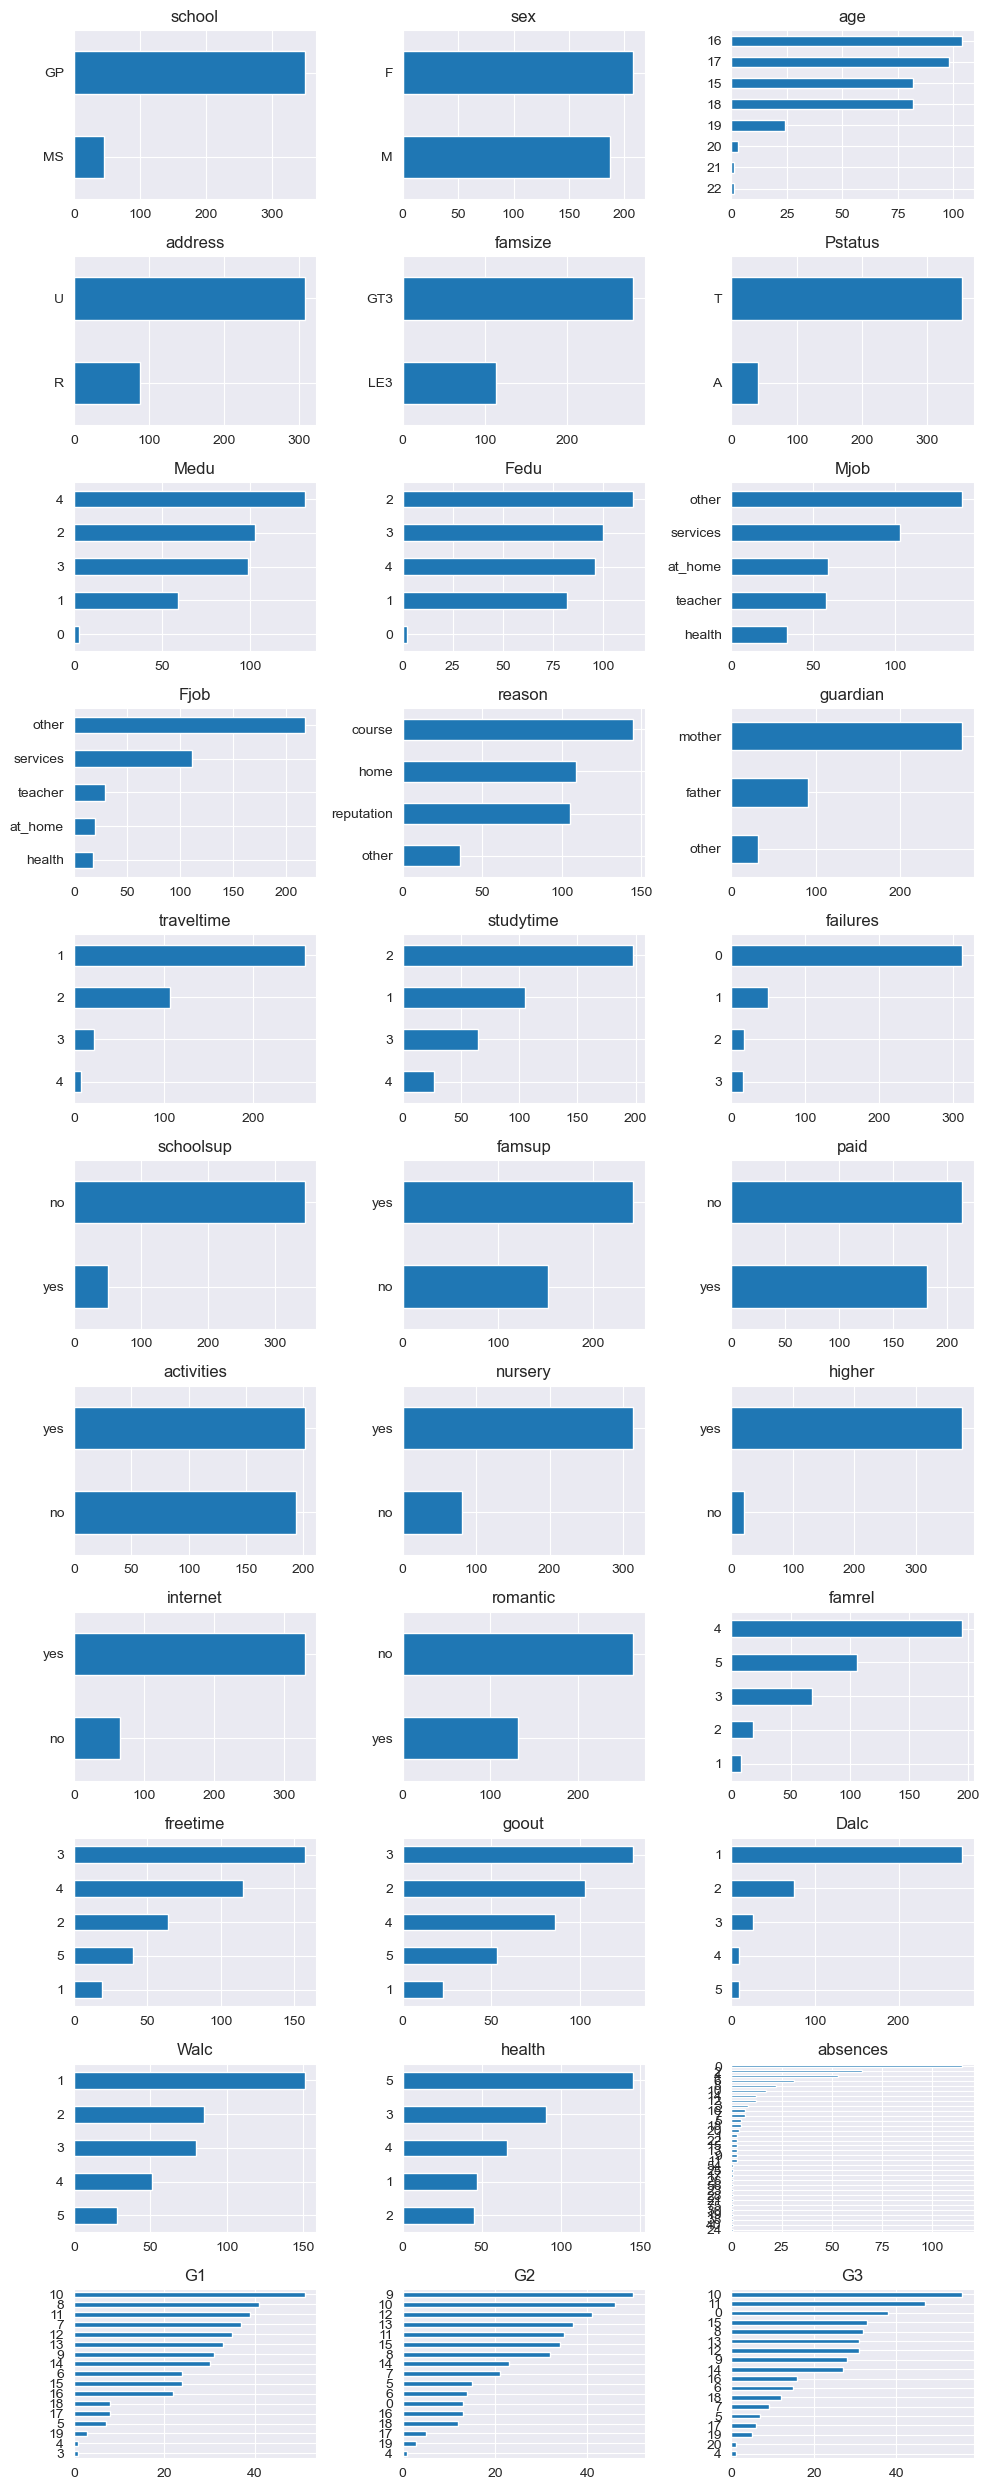

In [16]:
fig, axes = plt.subplots(
    nrows=int(np.ceil(len(df.columns) / 3)), ncols=3, figsize=(10, 25)
)

for ax, param in zip(axes.flat, df.columns):
    df[param].value_counts(ascending=True).plot(kind="barh", ax=ax)
    ax.set_title(param)
plt.tight_layout()
plt.show();

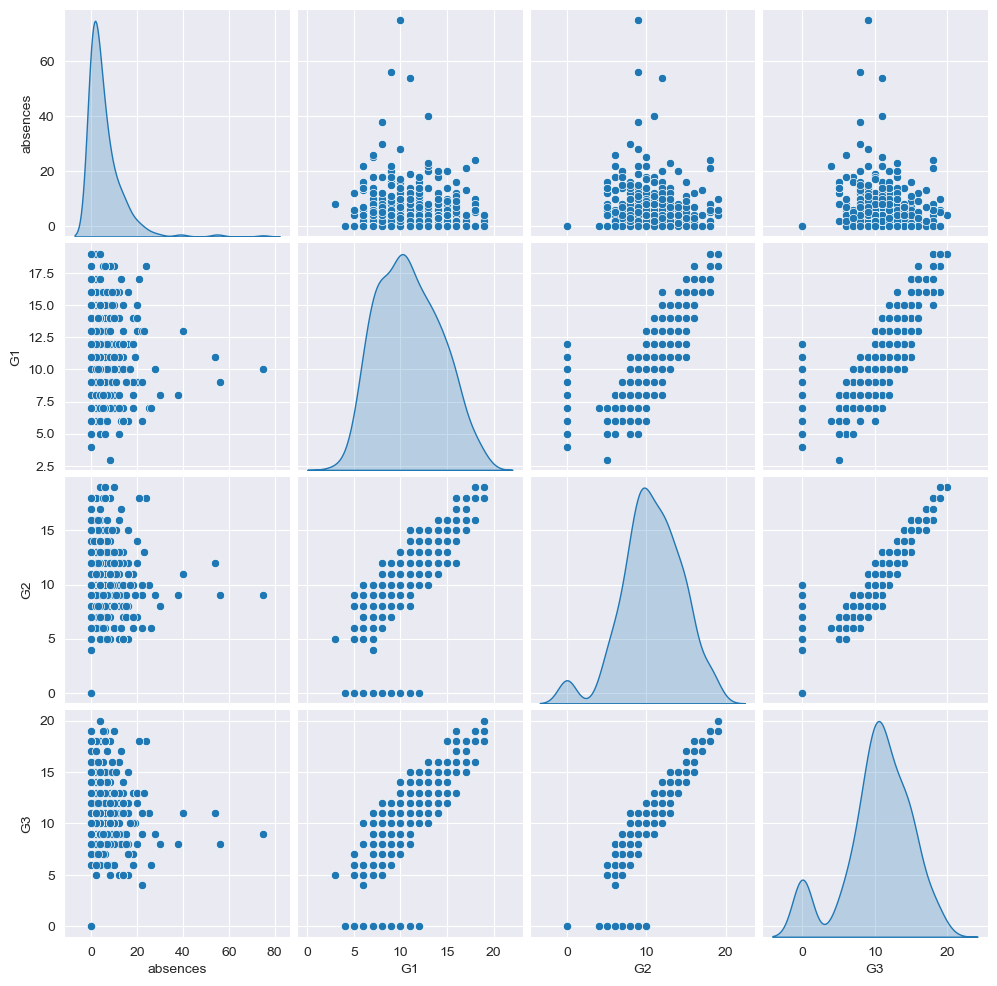

In [17]:
sns.pairplot(df.iloc[:,-4:], diag_kind='kde')  #  дополнительно посмотрим попарные графики рассеяния численных признаков

Теперь посмотрим как значения каждого из параметров влияют на итоговую оценку

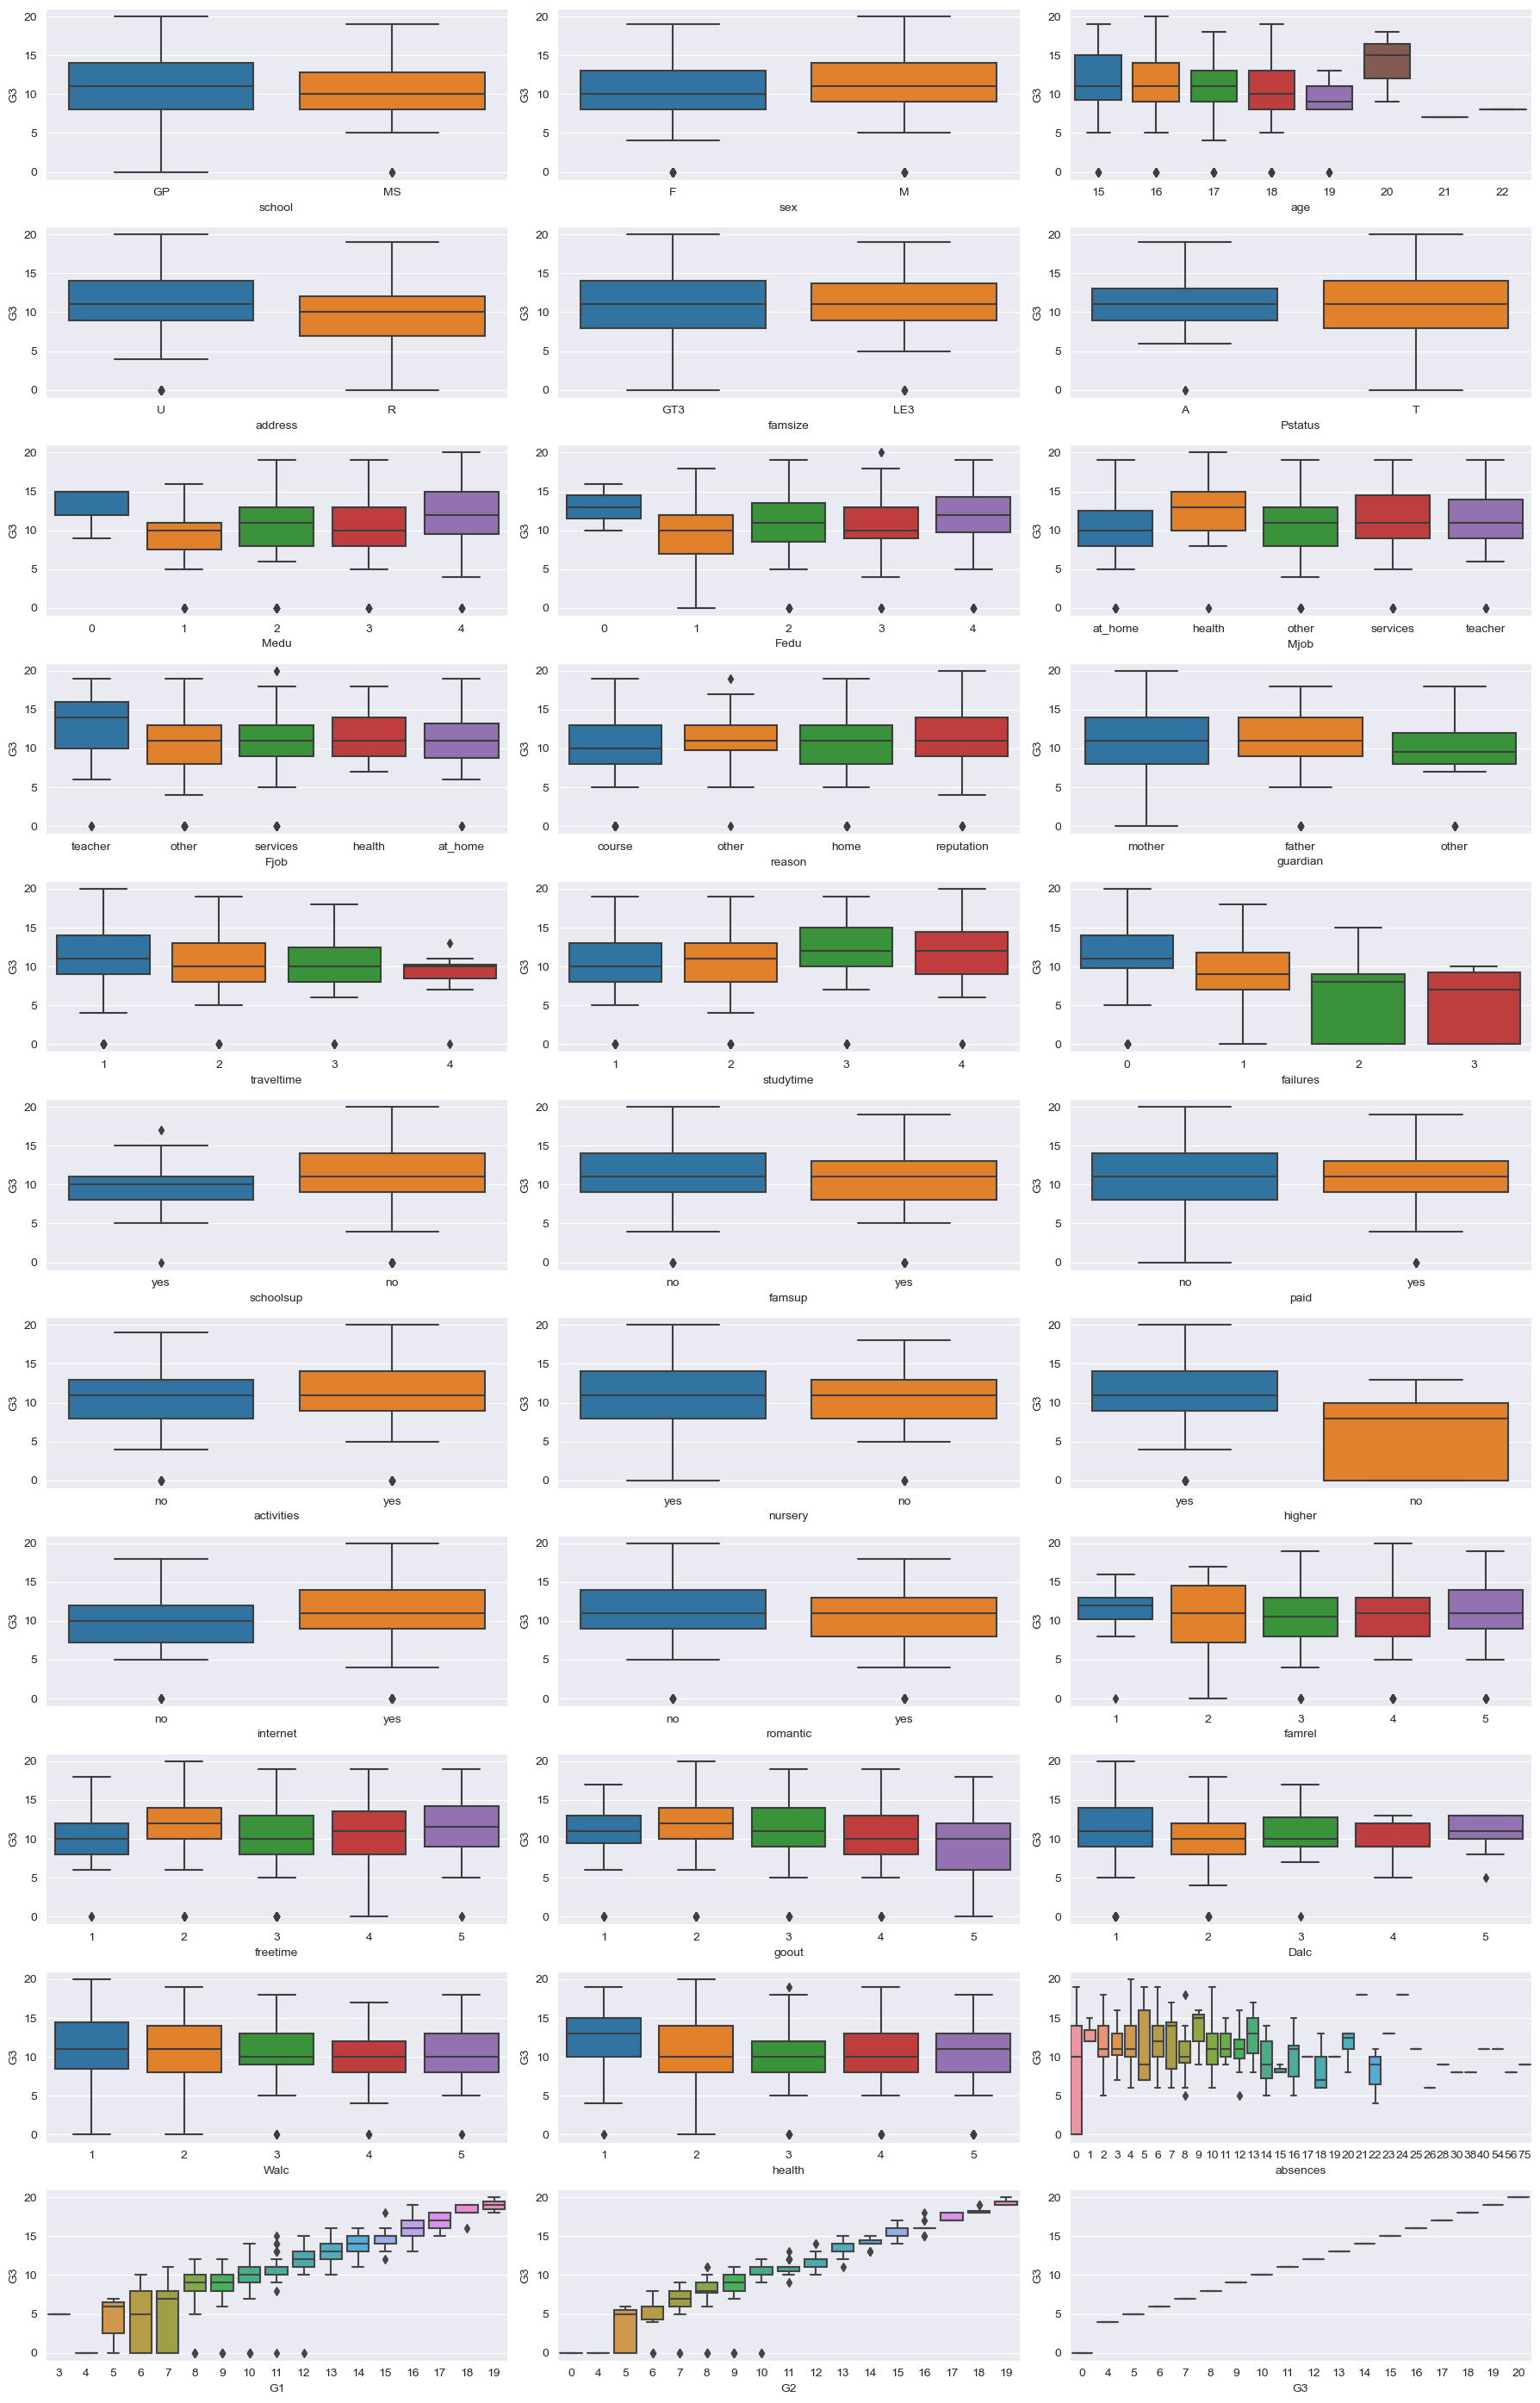

In [18]:
fig, axes = plt.subplots(
    nrows=int(np.ceil(len(df.columns) / 3)), ncols=3, figsize=(18, 28)
)
for ax, param in zip(axes.flat, df.columns):
    sns.boxplot(data=df, x=param, y="G3", ax=ax)
plt.tight_layout()
plt.show();

По графикам boxplot, можно сделать следующие выводы:
* sex: мужчины имеют слегка выше средние оценки G3 относительно женщин;
* age: возраст не коррелирует с G3, самые высокие оценки у 20-летних;
* higher: оценка у тех, кто хочет получить высшее образование существенно выше, чем у тех, кто не хочет;
* medu/fedu: отсутствие образования положительно сказывается на оценках. С чем это может быть это связано?

#### Корреляционный анализ

Построим сначала для численных признаков

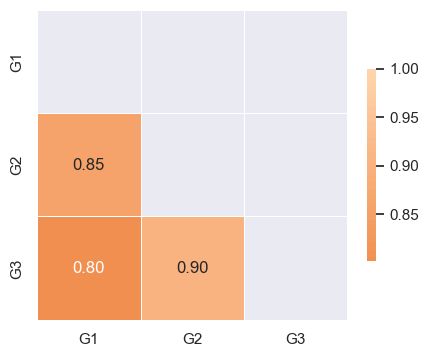

In [19]:
sns.set(font_scale=1.)
corr_matrix = df_cat[['G1','G2','G3']].corr(
    method="pearson"
) 

mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.heatmap(
    corr_matrix,
    mask=mask,
    vmax=1,
    center=0,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    ax=ax,
)
plt.show();

Для всех оставшихся признаков, используем метод Спирмана, так как остальные признаки категориальные и ранговые [Spearman](https://www.crispanalytics.io/post/what-type-of-correlation-is-appropriate-for-nominal-and-continuous-data)

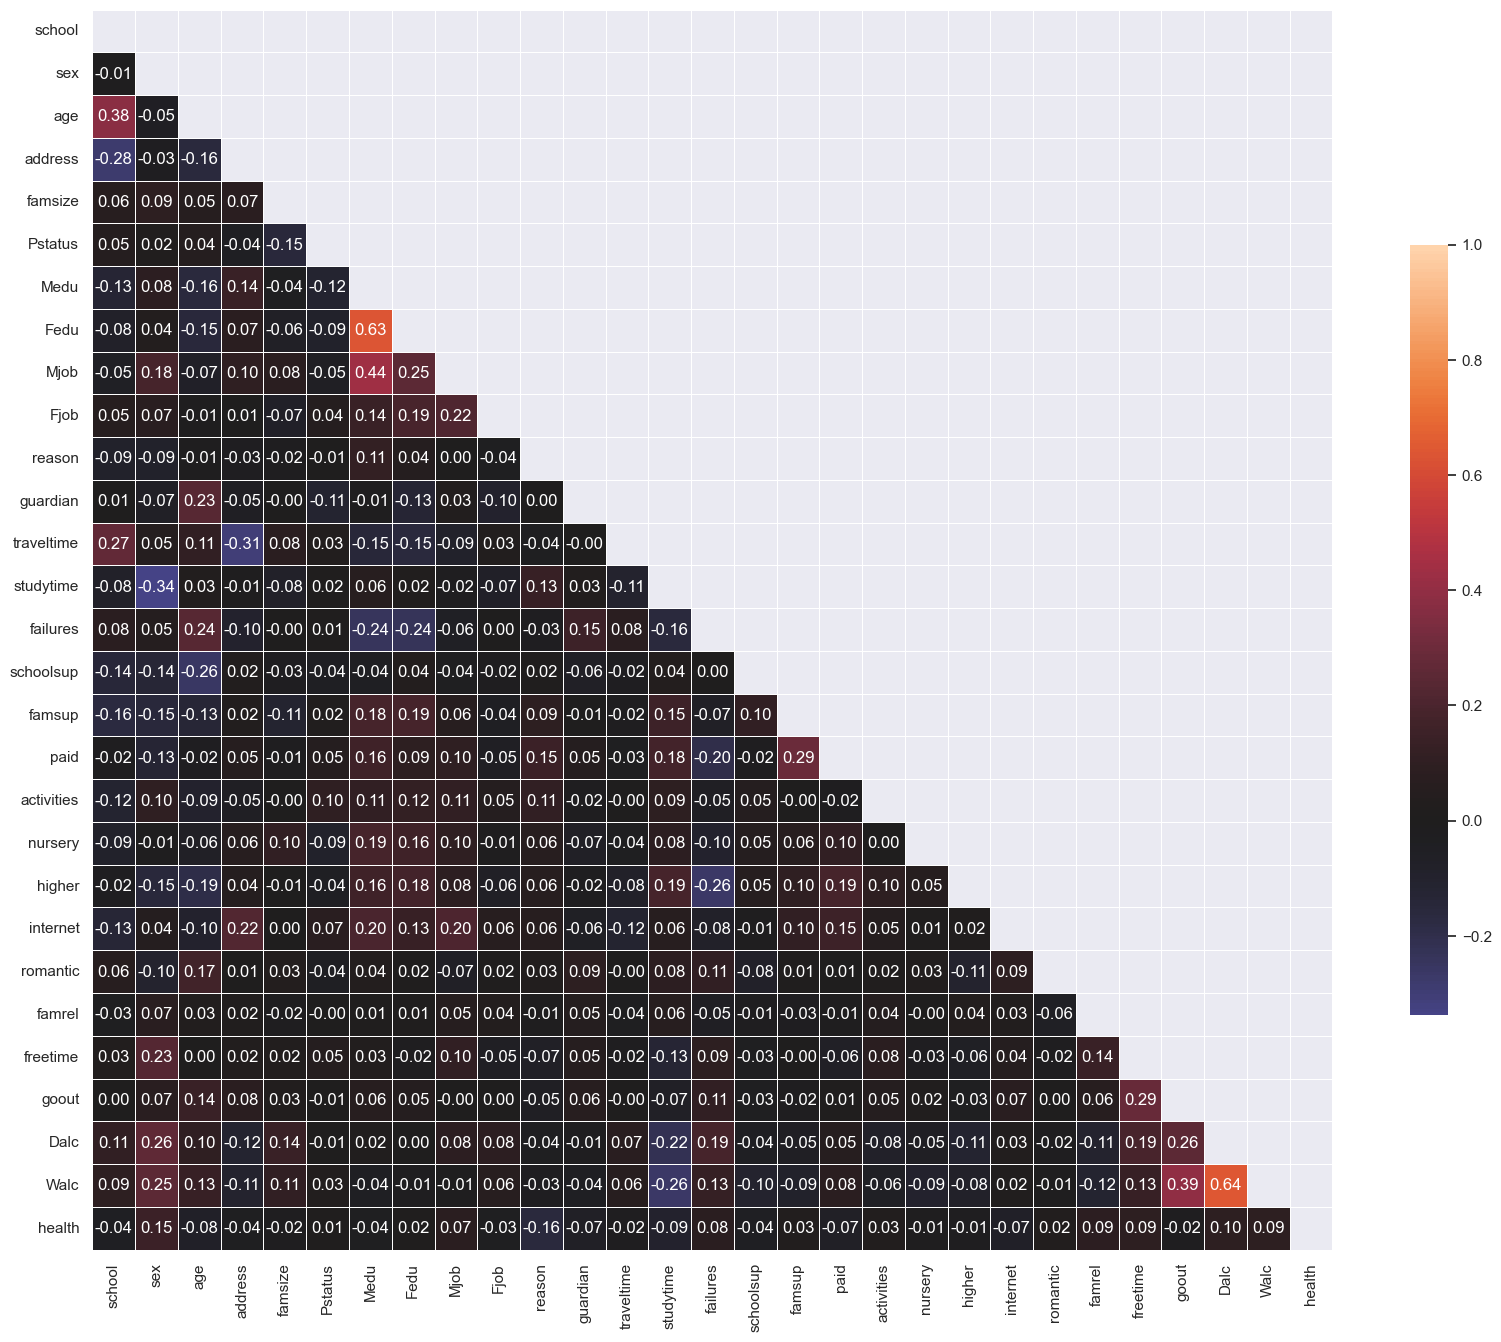

In [20]:
sns.set(font_scale=1.)
corr_matrix = df_cat.drop(['G1','G2', 'G3', 'absences'], axis=1).corr(
    method="spearman"
)

mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(1, 1, figsize=(20, 20))
sns.heatmap(
    corr_matrix,
    mask=mask,
    vmax=1,
    center=0,
    annot=True,
    fmt=".2f",
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    ax=ax,
)
plt.show();

Тут видно следующее:
* Оценки за первый и второй период (G1 и G2) сильно коррелируют с финальной оценкой (0.8 и 0.9 соответственно);
* Употребление алкоголя в будни и в выходные (Dalc и Wcalc) относительно сильно скоррелированы (0.64);
* Образование отца и матери (Fedu и Medu) относительно сильно скоррелированы (0.63);

### Проверка гипотез

$H_0$: в ген. совокупности нет разницы в оценках между биологическими полами
$H_1$: в ген. совокупности есть разница в оценках между биологическими полами

Дисперсия Male 21.37, Female 20.21
P-value нормальности Male 0.0003515, Female 7.62e-05


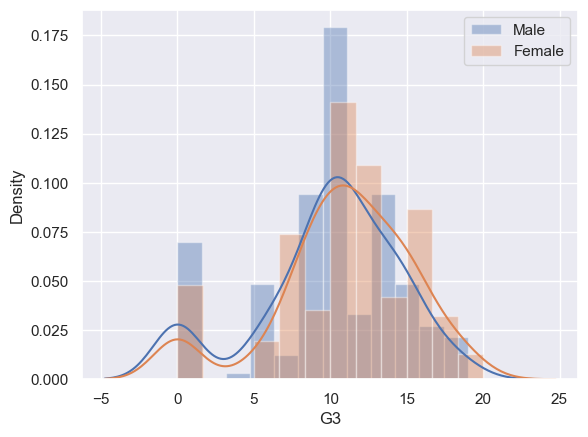

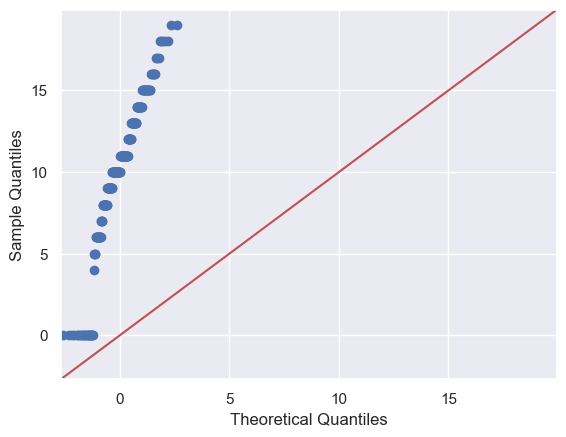

In [21]:
m = df[df['sex'] == 'F']['G3']
f = df[df['sex'] == 'M']['G3']

print(f'Дисперсия Male {np.round(m.var(), 2)}, Female {np.round(f.var(), 2)}')  # проверка одинаковости дисперсии
print(f'P-value нормальности Male {np.round(scipy.stats.normaltest(m)[1], 7)}, Female {np.round(scipy.stats.normaltest(f)[1], 7)}')

sns.distplot(m, label='Male')  # проверка нормальности распределения
sns.distplot(f, label='Female')
plt.legend()

sm.qqplot(m, line='45')
plt.show();

Используем тест Колмогорова-Смирнова для проверки распределения двух независимых переменных

In [22]:
scipy.stats.ks_2samp(f, m)  # 13% вероятность принять H1 (что существует разница в оценках между полами)

KstestResult(statistic=0.11481900452488687, pvalue=0.1345602485796754)

$H_0$: нет взаимосвязи между употреблением алгоколя в выхи и гулянками с друзьями
$H_1$: есть взаимосвязь между употреблением алгоколя в выхи и гулянками с друзьями

Используем тест независимости хи-вкадрат кактегориальных переменных

In [23]:
_, p_value, _, _ = scipy.stats.chi2_contingency(df[['Walc','goout']].pivot_table(index='Walc', columns='goout',
                                                                                  aggfunc=len, fill_value=0))

print(p_value)  #  <0.05 статистически значимо, отвергаем H0 при alpha = 0.05

2.50352859326213e-17


In [24]:
df[['Walc','goout']].pivot_table(index='Walc', columns='goout',
                                 aggfunc=len, fill_value=0)

goout,1,2,3,4,5
Walc,,,,,
1,15,54,47,26,9
2,4,29,37,9,6
3,2,12,35,22,9
4,2,6,7,23,13
5,0,2,4,6,16


### Линейная регрессия

Построим модель регрессии по двум числовым параметрам (G1, G2) для предсказания итоговой оценки

In [25]:
sm.OLS(df['G3'], df[['G1', 'G2']]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     G3   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                              6151.
Date:                Wed, 20 Dec 2023   Prob (F-statistic):                   2.71e-297
Time:                        00:00:15   Log-Likelihood:                         -834.58
No. Observations:                 395   AIC:                                      1673.
Df Residuals:                     393   BIC:                                      1681.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
G1             0.0067      0.051      0.132      0.895      -0.094       0.107
G2             0.9797      0.051     19.084      0.000       0.879       1.081
==============================================================================
Omnibus:                      261.432   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1976.762
Skew:                          -2.899   Prob(JB):                         0.00
Kurtosis:                      12.299   Cond. No.                         11.5
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Тут G1 не стат. значимый (P > alpha=0.05), попробуем убрать G1

In [26]:
sm.OLS(df['G3'], df['G2']).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                     G3   R-squared (uncentered):                   0.969
Model:                            OLS   Adj. R-squared (uncentered):              0.969
Method:                 Least Squares   F-statistic:                          1.233e+04
Date:                Wed, 20 Dec 2023   Prob (F-statistic):                   1.96e-299
Time:                        00:00:19   Log-Likelihood:                         -834.59
No. Observations:                 395   AIC:                                      1671.
Df Residuals:                     394   BIC:                                      1675.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
G2             0.9864      0.009    111.054      0.000       0.969       1.004
==============================================================================
Omnibus:                      261.397   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1976.711
Skew:                          -2.899   Prob(JB):                         0.00
Kurtosis:                      12.300   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

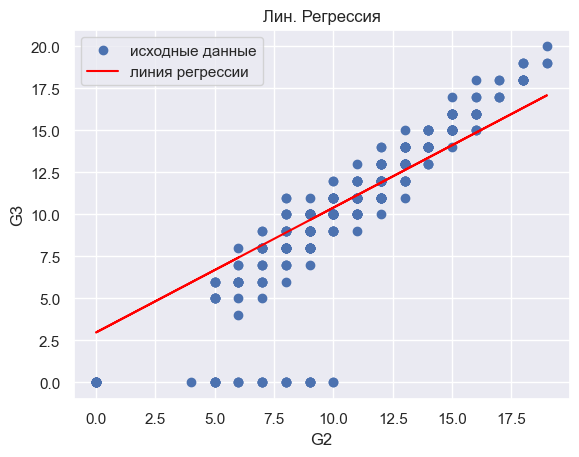

In [27]:
lin_model = scipy.stats.linregress(df['G3'], df['G2'])
plt.scatter(df['G2'], df['G3'], label='исходные данные')
plt.plot(df['G2'], lin_model.intercept + lin_model.slope*df['G2'], label='линия регрессии', color='red')
plt.xlabel('G2')
plt.ylabel('G3')
plt.title(f'Лин. Регрессия')
plt.legend();

### ДОПОЛНИТЕЛЬНО: Кластерный анализ

Попробуем визуализировать данные через нелинейное уменьшение размерности [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding), а потом применить методы кластеризации

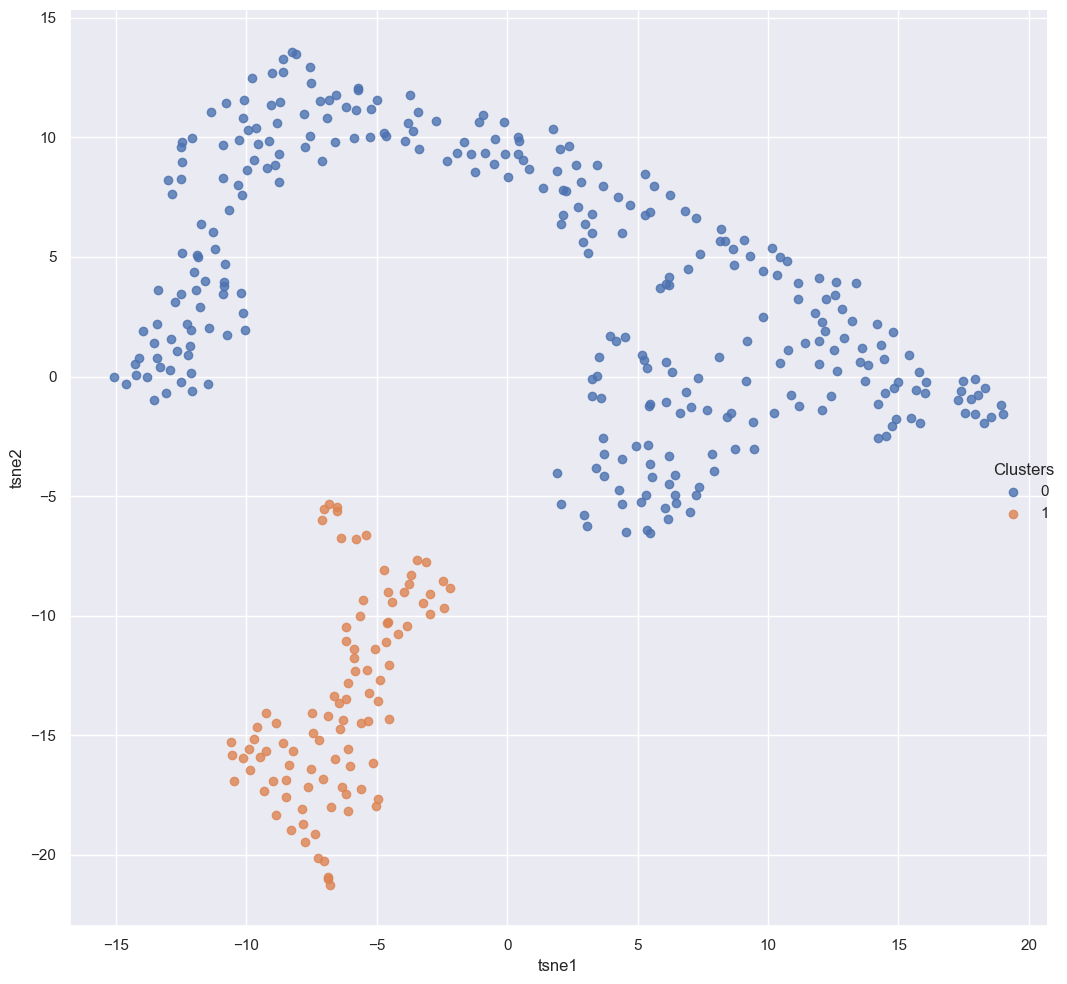

In [31]:
tsne_2d = TSNE(n_components=2, perplexity=42)  # стохастический процесс, требуется несколько раз запустить для удовлетворимого результата
tsne_repr_2d = tsne_2d.fit_transform(df_cat.drop('G3', axis=1))

df_cat["tsne1"] = tsne_repr_2d[:, 0]
df_cat["tsne2"] = tsne_repr_2d[:, 1]

labels_dbs = DBSCAN(eps=5, min_samples=20).fit_predict(tsne_repr_2d)
df_cat["Clusters"] = labels_dbs

sns.lmplot(
    "tsne1",
    "tsne2",
    data=df_cat,
    hue="Clusters",
    #            palette=sns.xkcd_palette(colors),
    fit_reg=False,
    height=10,
)

plt.tight_layout()
plt.show();

Отсюда видно, что данные могут кластеризоваться подгруппы. Это возможно может быть полезным для регрессии

### ДОПОЛНИТЕЛЬНО: Регрессия на решающих деревьях

Построим аппроксимационную модель, обучив регрессор на обучающей выборке. Так как параметры БД разнородные, то подходящим семейством алгоритмов будут алгоритмы, основанные на решающий деревьях

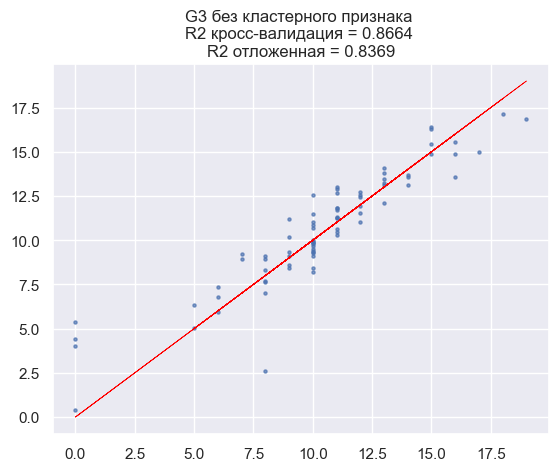

In [32]:
model = CatBoostRegressor(verbose=False)
X_train, X_test, y_train, y_test = train_test_split(
    df_cat.drop(["tsne1", "tsne2", "Clusters", "G3"], axis=1),
    df_cat["G3"],
    test_size=0.20,
    random_state=1,
)
pool_train = Pool(data=X_train, label=y_train)
pool_test = Pool(data=X_test, label=y_test)
model.fit(pool_train)

plt.plot(y_test, y_test, linewidth=0.5, color="red")
plt.scatter(y_test, model.predict(X_test), s=5, alpha=0.7)
plt.title(
    f"G3 без кластерного признака \n"
    f"R2 кросс-валидация = {np.round(cross_val_score(model, X_train, y_train, cv=5).mean(), 4)} \n"
    f"R2 отложенная = {np.round(r2_score(y_test, model.predict(X_test)), 4)}"
)
plt.show();

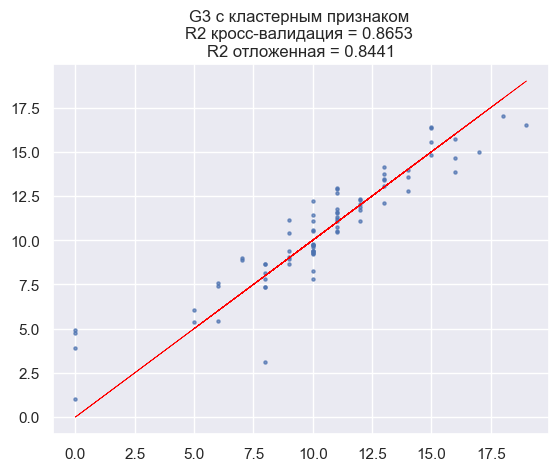

In [33]:
model = CatBoostRegressor(verbose=False)
X_train, X_test, y_train, y_test = train_test_split(
    df_cat.drop(["tsne1", "tsne2", "G3"], axis=1),
    df_cat["G3"],
    test_size=0.20,
    random_state=1,
)
pool_train = Pool(data=X_train, label=y_train)
pool_test = Pool(data=X_test, label=y_test)
model.fit(pool_train)

plt.plot(y_test, y_test, linewidth=0.5, color="red")
plt.scatter(y_test, model.predict(X_test), s=5, alpha=0.7)
plt.title(
    f"G3 c кластерным признаком \n"
    f"R2 кросс-валидация = {np.round(cross_val_score(model, X_train, y_train, cv=5).mean(), 4)} \n"
    f"R2 отложенная = {np.round(r2_score(y_test, model.predict(X_test)), 4)}"
)
plt.show();

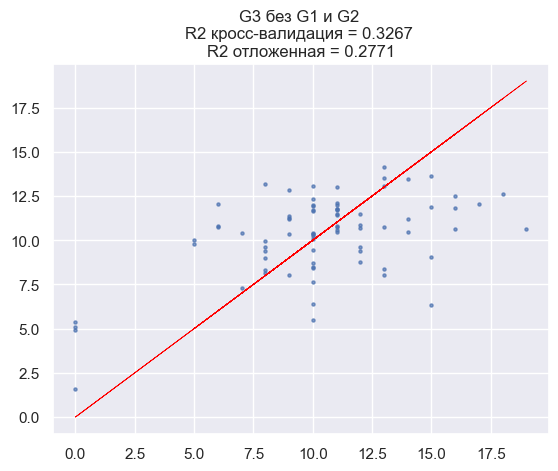

In [34]:
model = CatBoostRegressor(verbose=False)
X_train, X_test, y_train, y_test = train_test_split(
    df_cat.drop(["tsne1", "tsne2", "G1", "G2", "G3"], axis=1),
    df_cat["G3"],
    test_size=0.20,
    random_state=1,
)
pool_train = Pool(data=X_train, label=y_train)
pool_test = Pool(data=X_test, label=y_test)
model.fit(pool_train)

plt.plot(y_test, y_test, linewidth=0.5, color="red")
plt.scatter(y_test, model.predict(X_test), s=5, alpha=0.7)
plt.title(
    f"G3 без G1 и G2 \n"
    f"R2 кросс-валидация = {np.round(cross_val_score(model, X_train, y_train, cv=5).mean(), 4)} \n"
    f"R2 отложенная = {np.round(r2_score(y_test, model.predict(X_test)), 4)}"
)
plt.show();

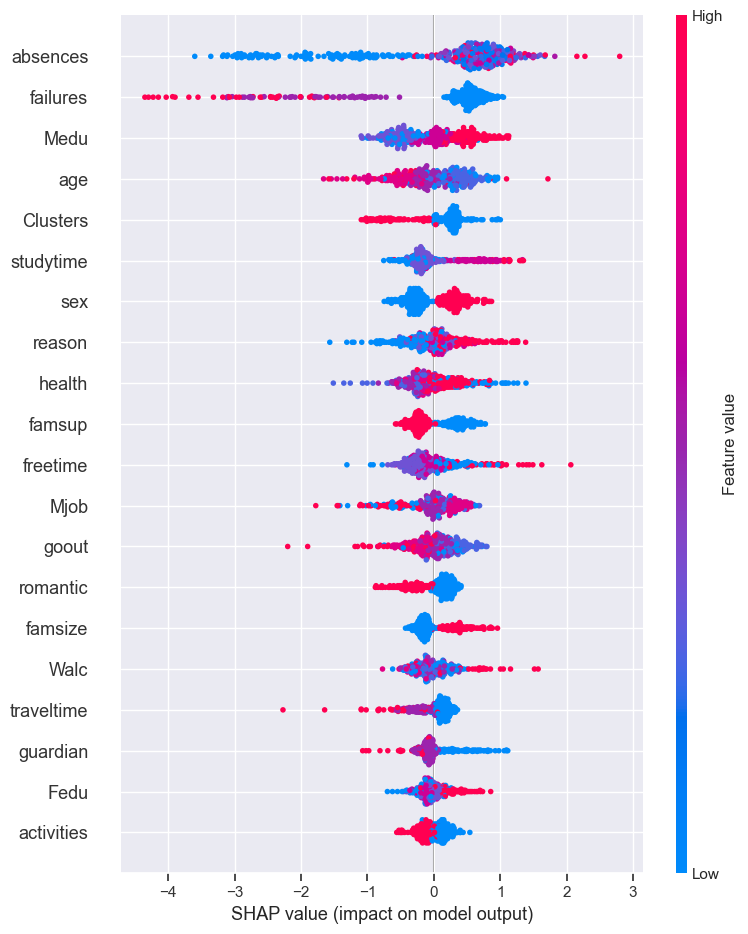

In [35]:
shap.summary_plot(shap.TreeExplainer(model).shap_values(df_cat.drop(["tsne1", "tsne2", "G1", "G2", "G3"], axis=1)), df_cat.drop(["tsne1", "tsne2", "G1", "G2", "G3"], axis=1))  # Важность признаков модели CatBoost без G1 и G2

In [36]:
pd.concat([df.loc[X_test.index]['G3'].reset_index(drop=True),
           np.ceil(pd.Series(model.predict(X_test), name='Предсказанные значения')).astype(int)], axis=1)

,G3,Предсказанные значения
0,0,5
1,10,9
2,8,10
3,10,11
4,10,8
...,...,...
74,12,10
75,11,12
76,10,6
77,13,15
